# GANによる異常検知

In [24]:
!gpustat

s2                   Tue Apr 21 19:35:14 2020  440.44
[0] Quadro RTX 8000  | 54'C,  23 % |  2597 / 48601 MB | taoli(2583M)
[1] Quadro RTX 8000  | 27'C,   0 % |   745 / 48601 MB | hasegawa(733M)
[2] Quadro RTX 8000  | 25'C,   0 % |  1765 / 48601 MB | inoue(1753M)
[3] Quadro RTX 8000  | 25'C,   0 % |    12 / 48601 MB |
[4] Quadro RTX 8000  | 59'C,  91 % |  5178 / 48601 MB | taoli(2581M) taoli(2581M)
[5] Quadro RTX 8000  | 48'C,   1 % |  2595 / 48601 MB | taoli(2581M)
[6] Quadro RTX 8000  | 49'C,  75 % |  2595 / 48601 MB | taoli(2581M)
[7] Quadro RTX 8000  | 50'C,  88 % |  2595 / 48601 MB | taoli(2581M)


In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 6-3 Efficient GANの概要
AnoGANではテスト画像に対して異常検知をするのにまずテスト画像と最も近い画像を作ることのできる生成ノイズを学習する必要があり，異常検知に時間がかかってしまう問題があった．本節ではその問題を解決するためにEfficient GANを理解する

### Efficient GAN
Efficient GANではテスト画像から生成ノイズzを生成するエンコーダEを新たに作る．つまりこれは生成器Gとは逆の作用をしていて${\rm G}^{-1}$と表すことができる．このEについては通常通りGANを生成した後に独立に作ろうとすると上手くいかないらしい．なのでここではG,D,Eを同時に作る手順を理解する．

### Encoderを作る方法，後から作る作戦が上手くいかない理由
- [Adversarially learned inference](https://arxiv.org/pdf/1606.00704.pdf)
- [Adversarially learned inference GitHub page](https://ishmaelbelghazi.github.io/ALI/)


詳しくは上のサイトの図を参照するのがわかりやすい．それぞれの方法で作成したEncoderについて二次元データ(本来は画像を用いるところ)を入力して，生成ノイズzの空間に写像させた時に本来GANの入力ノイズは平均0,　分散1の均一な空間になると基づいて設計されているが適切な学習をさせていないEncoderの写像はそのような空間になっていない．つまりこれは平均0, 分散1の生成ノイズに対して上手く画像を生成できないことを意味している．

この直感的な理由の理解としては，Generatorが入力データの平均や分散を完全に理解していれば問題ないがそれは現実的には困難であり，不完全に学習したGeneratorを基にして学習するよりは本来学習の基にすべきである教師データを基にEncoderも学習するべきであるというように考えることができる．


### EncoderをGANと同時に作る方法
今回はEncoderを教師データの画像xと関与させるために**BiGAN(Bidiretional GAN)** と呼ばれる仕組みを利用する．
BiGANではDiscriminatorに対して$(x, E(x))$と$(G(z), z)$を入力する．

つまり元々のDCGANの損失関数とBiGANの損失関数を比較すると
- Discriminator
$$
-\sum_{i=1}^M\log D(x) -\sum_{j=1}^M \log(1-D(G(z))
$$
$$
-\sum_{i=1}^M[\log  D(x_i, E(x_i)-\sum_{j=1}^M  \log(1-D(G(z_j), z_j))]
$$

- Generator
$$
-\sum_{j=1}^M\log D(G(z_j))
$$
$$
-\sum_{j=1}^M\log D(G(z_j), z_j)
$$

ここでEncoderの損失関数を考えると，EncoderはDiscriminatorを騙せると嬉しいので，Discriminatorの損失関数にマイナスをかけてEncoderに関与するところだけを取り出すと
- Encoder

$\sum_{i=1}^M\log D(x_i, E(x_i))$
となる．しかしGeneratorと同様にこのままでは学習が進まないので以下のようにする．
$$
- \sum_{i=1}^M\log (1- D(x_i, E(x_i)))
$$


## 6-4 Efficient GANの実装と異常検知の実施
mnistの7と8の画像を正常画像としてGANを学習する．この時画像サイズが64ピクセル平方ではなく28ピクセル平方であることに注意が必要．Encoderも同時に学習させることも含めて前に作ったGANの学習ずみモデルをここに適用することができないのでサイド学習させる必要がある．

### GeneratorとDiscriminatorの実装

In [7]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        
        # 転置畳み込み層にいれるテンソルに形を変形する
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)
        
        return out

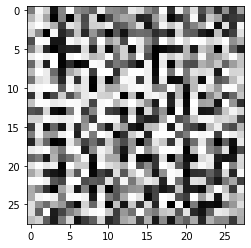

In [8]:
# 動作確認
G = Generator(z_dim=20)
G.train()

# Batch_Normがあるのでミニバッチは２以上の数
input_z = torch.randn(2,20)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed,"gray")
plt.show()

BiGANのモデルでは識別器Dに対して画像データxだけではなく入力ノイズzも入力します．これら２つは畳み込み層と全結合層で別々に処理された後に結合される．結合には```torch.cat()```を利用し，その後再度全結合層にて処理をする．

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        # 入力画像の処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # 白黒なのでinput_channel = 1
            nn.LeakyReLU(0.1, inplace=True))
        
        self.x_layer2 =  nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1), # 白黒なのでinput_channel = 1
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 乱数の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),  # (3648 - 512)**0.5 = 56
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)
        
        
    def forward(self, x, z):
        
        # 画像
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        # 乱数
        z = z.view(z.shape[0],-1)
        z_out = self.z_layer1(z)
        
        # x_out と z_out の結合 
        # その後全結合層
        x_out = x_out.view(-1, 64*7*7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        feature = out
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last2(out)
        
        return out , feature

In [10]:
# 動作確認
D = Discriminator(z_dim=20)

input_z = torch.randn(2,20)
fake_images = G(input_z)

d_out, _ = D(fake_images, input_z)

print(nn.Sigmoid()(d_out))

tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward>)


### Encoderの実装
出力サイズが一次元ではなく```z_dim```になることに注意

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1), # 白黒なので　input_channel = 1
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))
        
        # ここまでで画像サイズが7×7
        self.last = nn.Linear(128*7*7, z_dim)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # LInearに入力するために整形する
        out = out.view(-1, 128*7*7)
        out = self.last(out)
        
        return out

In [12]:
# 動作確認
E = Encoder(z_dim=20)

x = fake_images # とりあえず代用

z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2612, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3682, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4398,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4818]], grad_fn=<AddmmBackward>)


### DataLoaderの実装
DCGANのDataLoaderと同じだが画像サイズが異なるのでパスだけ変える

In [13]:
def make_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
        img_path = "./data/img_78_28size/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
    return train_img_list


class ImageTransform():
    """
    画像クラスの前処理
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)
    

class GAN_Img_Dataset(data.Dataset):
    """
    画像のDataset
    """
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
            
    def __len__(self):
        """画像の枚数を返す"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        """前処理をした画像のTensor形式のデータを取得"""
        
        img_path = self.file_list[index]
        img = Image.open(img_path) #H,W,C
        
        # 前処理
        img_transformed = self.transform(img)
        
        return img_transformed

In [14]:
# DataLoaderの作成
train_img_list = make_datapath_list()
# print(train_img_list)

# Datasetの作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(train_img_list, ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = batch_size, shuffle=True)

torch.Size([64, 1, 28, 28])


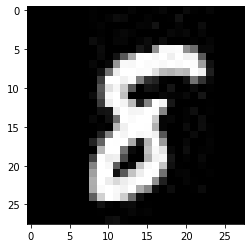

In [15]:
#動作確認
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())
img_transformed = imges[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

### Efficient GANの学習
Encoderを追加する以外はDCGANと同じであるが，Discriminatorの学習率を低めに設定してある．これはDiscriminatorはGeneratorとEncoderの２つに対して学習をするので学習する機会が多いので学習率を下げることによって１つだけが学習が過度に進んで全体として学習が進まなくなるのを防ぐ

In [16]:
def train_model(G, D, E, dataloader, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス : ", device)
    
    # 最適化手法の適用
    lr_ge = 0.0001
    lr_d = lr_ge/4.0
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    
    # 損失関数
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    z_dim = 20
    mini_batch_size = 64
    
    G.to(device)
    D.to(device)
    E.to(device)
    
    G.train()
    D.train()
    E.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションのカウンタをセット
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        epoch_e_loss = 0.0
        if ((epoch+1)%50==0):
            print("-----------------------------------")
            print("Epoch {}/{} ".format(epoch, num_epochs))
            print("-----------------------------------")
            print("---  (train)  ---")

        # dataloader からmini_batchずつデータを取り出す
        for imges in dataloader:
            
            # batch_norm の　エラーを回避
            if imges.size()[0] == 1:
                continue
                
            
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,),1).to(device)
            label_fake = torch.full((mini_batch_size,),0).to(device)
            
            imges = imges.to(device)
            
            
            """D"""
            # 前半部分
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            #　後半部分
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差の計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
        
            #  backward
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            

            """G"""
            # 偽画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差の計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # backward
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
             
            
            """E"""
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 誤差の計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # backward
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            
            
            """記録"""
            epoch_d_loss += d_loss.item()
            epoch_e_loss += e_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        if ((epoch+1)%100==0):
            t_epoch_finish = time.time()
            print('-------------')
            print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
                epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
            print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()
            
            if ((epoch+1)%num_epochs==0):
                torch.save(G.state_dict(), "weights/bigan_g_"+str(epoch+1) + ".pth")
                torch.save(D.state_dict(), "weights/bigan_d_"+str(epoch+1) + ".pth")
                torch.save(E.state_dict(), "weights/bigan_e_"+str(epoch+1) + ".pth")
            
            
    print("総イテレーション回数:", iteration)
    
    return G, D, E

In [17]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

In [27]:
init_flag = 1
model_epoch_num = 1500

G = Generator(z_dim = 20)
D = Discriminator(z_dim = 20)
E = Encoder(z_dim = 20)

if init_flag == 0:

    # 初期化の実施
    G.apply(weights_init)
    E.apply(weights_init)
    D.apply(weights_init)

    print("ネットワークの初期化完了")
    
else:

#     学習済みモデルの適用
    G.to(device)
    D.to(device)
    E.to(device)

    g_weights = torch.load("weights/bigan_g_"+ str(model_epoch_num)+ ".pth",
                            map_location={'cuda:0': 'cpu'})
    d_weights = torch.load("weights/bigan_d_"+ str(model_epoch_num)+ ".pth",
                            map_location={'cuda:0': 'cpu'})
    e_weights = torch.load("weights/bigan_e_"+ str(model_epoch_num)+ ".pth",
                            map_location={'cuda:0': 'cpu'})


    print(G.load_state_dict(g_weights))
    print(D.load_state_dict(d_weights))
    print(E.load_state_dict(e_weights))
    
    G_update = G
    D_update = D
    E_update = E

    print("ネットワークのモデル適用完了")


<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
ネットワークのモデル適用完了


In [23]:
num_epochs  = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス :  cuda:0
-----------------------------------
Epoch 49/1500 
-----------------------------------
---  (train)  ---
-----------------------------------
Epoch 99/1500 
-----------------------------------
---  (train)  ---
-------------
epoch 99 || Epoch_D_Loss:0.0259 ||Epoch_G_Loss:0.3344 ||Epoch_E_Loss:0.3489
timer:  1.0023 sec.
-----------------------------------
Epoch 149/1500 
-----------------------------------
---  (train)  ---
-----------------------------------
Epoch 199/1500 
-----------------------------------
---  (train)  ---
-------------
epoch 199 || Epoch_D_Loss:0.1382 ||Epoch_G_Loss:0.1236 ||Epoch_E_Loss:0.1339
timer:  1.2601 sec.
-----------------------------------
Epoch 249/1500 
-----------------------------------
---  (train)  ---
-----------------------------------
Epoch 299/1500 
-----------------------------------
---  (train)  ---
-------------
epoch 299 || Epoch_D_Loss:0.1300 ||Epoch_G_Loss:0.1201 ||Epoch_E_Loss:0.1249
timer:  1.0201 sec.
-----------------

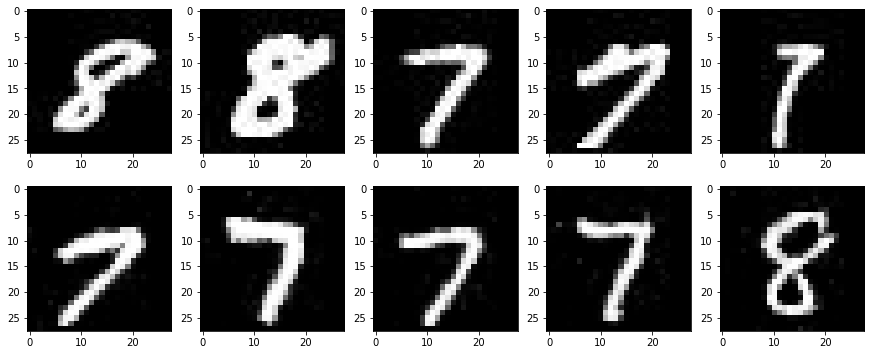

In [28]:
# 生成画像と訓練データを可視化する
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

### Efficient GANによる異常検知

In [43]:
# DataLoaderの作成

def make_test_datapath_list():
    
    test_img_list = list()
    
    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx) + ".jpg"
        test_img_list.append(img_path)
        
        img_path = "./data/test_28size/img_8_" + str(img_idx) + ".jpg"
        test_img_list.append(img_path)
        
        img_path = "./data/test_28size/img_2_" + str(img_idx) + ".jpg"
        test_img_list.append(img_path)
    
    return test_img_list

# ファイルリストの作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform = ImageTransform(mean, std))


# DataLoaderの作成

batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

In [52]:
test_img_list

['./data/test_28size/img_7_0.jpg',
 './data/test_28size/img_8_0.jpg',
 './data/test_28size/img_2_0.jpg',
 './data/test_28size/img_7_1.jpg',
 './data/test_28size/img_8_1.jpg',
 './data/test_28size/img_2_1.jpg',
 './data/test_28size/img_7_2.jpg',
 './data/test_28size/img_8_2.jpg',
 './data/test_28size/img_2_2.jpg',
 './data/test_28size/img_7_3.jpg',
 './data/test_28size/img_8_3.jpg',
 './data/test_28size/img_2_3.jpg',
 './data/test_28size/img_7_4.jpg',
 './data/test_28size/img_8_4.jpg',
 './data/test_28size/img_2_4.jpg']

### 異常度を検出するAnomaly_scoreを実装
以下の実装での```fake_img```はテスト画像xをEに入力して求めた入力ノイズzをGに再構成したものである．

入力画像x → E(x)=z(入力ノイズ) → z → G(z) = fake_img → D(fake_img) = y

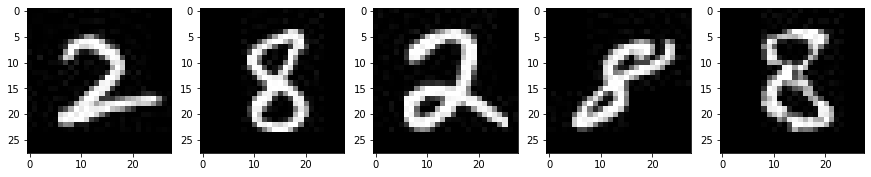

In [59]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [54]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda = 0.1):
    
    # テスト画像x と　生成画像 fake_img のピクセルレベルの差異を出す
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # テスト画像と生成画像をDiscriminatorに判断させる
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    """この部分が変化"""
    
    # discrimination_loss を residual_loss と同様に求める
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
#     # mini_batchごとにlossを求める
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # mini_batch全部の損失を求める
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

total loss： [226. 205. 266. 155. 196.]


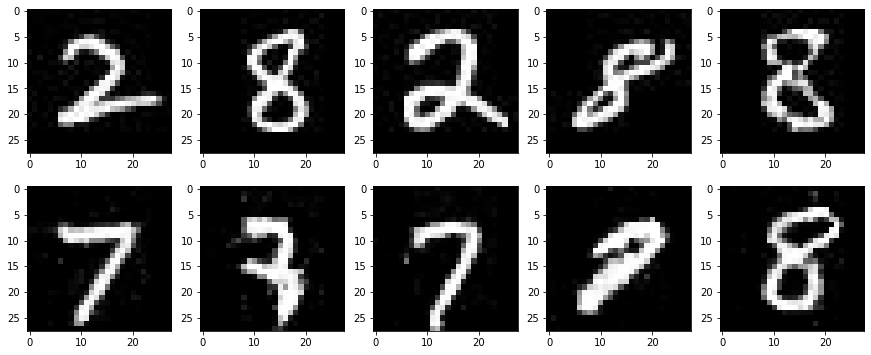

In [60]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 教師データの画像をエンコードしてzにしてから、Gで生成
z_out_real = E_update(x)
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')